<a href="https://colab.research.google.com/github/RakinduM/AI-weather-forecast/blob/feat%2Ftrain-a-model-using-MLP/train_a_model_using_MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Setup — packages and runtime notes

In [2]:
# Colab-specific: install packages if necessary (uncomment if you need to install)
# !pip install -q tensorflow==2.11.0 scikit-learn joblib

import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn.utils import class_weight
import joblib
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

# Path to CSV (change if needed)
DATA_PATH = "/content/weatherAUS 2.csv"  # <-- update if your file path differs

# Check GPU (Colab: Runtime -> Change runtime type -> GPU)
print("TensorFlow version:", tf.__version__)
print("GPU available:", tf.config.list_physical_devices('GPU'))


TensorFlow version: 2.19.0
GPU available: []


Load dataset

In [4]:
# Load data
assert os.path.exists(DATA_PATH), f"CSV not found at {DATA_PATH}. Upload to that path or change DATA_PATH."
df = pd.read_csv(DATA_PATH)
print("Dataset loaded. Shape:", df.shape)
df.head()


Dataset loaded. Shape: (145460, 23)


,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


Quick EDA (do this to understand the dataset)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

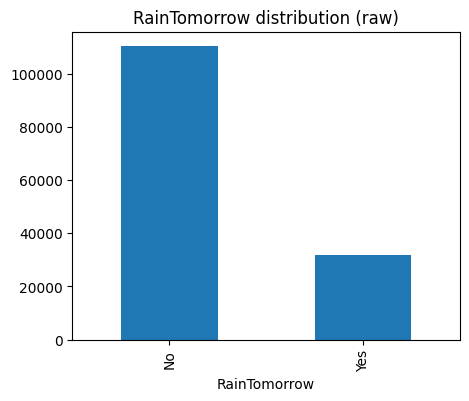

In [5]:
# Basic info
print(df.info())
print("\nTarget counts (include NaNs):")
if 'RainTomorrow' in df.columns:
    print(df['RainTomorrow'].value_counts(dropna=False))
else:
    raise ValueError("RainTomorrow target column not found in dataset.")

# Percent missing per column
missing = df.isnull().mean().sort_values(ascending=False)
print("\nMissing values fraction:")
print(missing[missing > 0].head(30))

# Plot target balance
plt.figure(figsize=(5,4))
df['RainTomorrow'].map({'Yes':1,'No':0}).value_counts().plot(kind='bar')
plt.title('RainTomorrow distribution (raw)')
plt.xticks([0,1], ['No','Yes'])
plt.show()


Preprocessing & Feature Engineering

Notes:

We'll produce a clean, reproducible preprocessing pipeline in a Preprocessor class to use when training and later for inference.

Strategy:

- Convert date → Month, DayOfWeek, Season

- Numeric: impute median, then StandardScaler

- Categorical: fill missing with 'Missing', then One-Hot (for MLP)

- Optionally create lag features (yesterday rain) — kept commented but included

In [6]:
# Preprocessing configuration
NUMERIC_FEATURES = [
    'MinTemp','MaxTemp','Rainfall','Evaporation','Sunshine',
    'WindGustSpeed','WindSpeed9am','WindSpeed3pm',
    'Humidity9am','Humidity3pm','Pressure9am','Pressure3pm',
    'Temp9am','Temp3pm'
]
# intersection with actual columns
NUMERIC_FEATURES = [c for c in NUMERIC_FEATURES if c in df.columns]

CATEGORICAL_FEATURES = ['Location','WindGustDir','WindDir9am','WindDir3pm']
CATEGORICAL_FEATURES = [c for c in CATEGORICAL_FEATURES if c in df.columns]

TARGET = 'RainTomorrow'

print("Numeric features used:", NUMERIC_FEATURES)
print("Categorical features used:", CATEGORICAL_FEATURES)


Numeric features used: ['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Temp9am', 'Temp3pm']
Categorical features used: ['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm']


Preprocessor class (fit on training data, transform train/test/inference)

In [7]:
class PreprocessorMLP:
    def __init__(self, numeric_features, categorical_features, scaler=None, ohe=None):
        self.numeric_features = numeric_features
        self.categorical_features = categorical_features
        self.scaler = scaler if scaler is not None else StandardScaler()
        self.num_imputer = SimpleImputer(strategy='median')
        self.cat_imputer = SimpleImputer(strategy='constant', fill_value='Missing')
        self.ohe = ohe if ohe is not None else OneHotEncoder(sparse=False, handle_unknown='ignore')
        self.fitted = False

    def fit(self, df):
        # Dates -> features
        if 'Date' in df.columns:
            df = df.copy()
            df['Date'] = pd.to_datetime(df['Date'])
            df['Month'] = df['Date'].dt.month
            df['DayOfWeek'] = df['Date'].dt.dayofweek
            # optional season
            df['Season'] = ((df['Month'] % 12 + 3) // 3)
            # keep season as category
            if 'Season' not in self.categorical_features:
                self.categorical_features = self.categorical_features + ['Season']
        # Numeric pipeline fit
        X_num = df[self.numeric_features]
        X_num = self.num_imputer.fit_transform(X_num)
        self.scaler.fit(X_num)
        # Categorical fit
        X_cat = df[self.categorical_features].astype(str)
        X_cat = self.cat_imputer.fit_transform(X_cat)
        self.ohe.fit(X_cat)
        self.fitted = True

    def transform(self, df):
        assert self.fitted, "Call fit first."
        df = df.copy()
        if 'Date' in df.columns:
            df['Date'] = pd.to_datetime(df['Date'])
            df['Month'] = df['Date'].dt.month
            df['DayOfWeek'] = df['Date'].dt.dayofweek
            df['Season'] = ((df['Month'] % 12 + 3)//3)
            if 'Season' not in self.categorical_features:
                self.categorical_features = self.categorical_features + ['Season']
        # numeric transform
        X_num = df[self.numeric_features]
        X_num = self.num_imputer.transform(X_num)
        X_num = self.scaler.transform(X_num)
        # categorical transform
        X_cat = df[self.categorical_features].astype(str)
        X_cat = self.cat_imputer.transform(X_cat)
        X_ohe = self.ohe.transform(X_cat)
        # final concatenated input for MLP
        X = np.hstack([X_num, X_ohe])
        return X

    def save(self, path):
        joblib.dump({
            'num_imputer': self.num_imputer,
            'scaler': self.scaler,
            'cat_imputer': self.cat_imputer,
            'ohe': self.ohe,
            'numeric_features': self.numeric_features,
            'categorical_features': self.categorical_features
        }, path)

    def load(self, path):
        data = joblib.load(path)
        self.num_imputer = data['num_imputer']
        self.scaler = data['scaler']
        self.cat_imputer = data['cat_imputer']
        self.ohe = data['ohe']
        self.numeric_features = data['numeric_features']
        self.categorical_features = data['categorical_features']
        self.fitted = True


Train/Test split + fit preprocessor

In [9]:
# Drop rows with missing target
df = df[~df[TARGET].isna()].copy()
df[TARGET] = df[TARGET].map({'Yes':1,'No':0})

# Optionally reduce dataset size in early experiments:
# df = df.sample(frac=0.5, random_state=RANDOM_SEED)

train_df, test_df = train_test_split(df, test_size=0.2, stratify=df[TARGET], random_state=RANDOM_SEED)

pre = PreprocessorMLP(NUMERIC_FEATURES, CATEGORICAL_FEATURES)
pre.fit(train_df)

X_train = pre.transform(train_df)
X_test  = pre.transform(test_df)

y_train = train_df[TARGET].values
y_test  = test_df[TARGET].values

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)


ValueError: Input y contains NaN.

Build the MLP model (Keras)

Design notes:

- Input dimension = number of numerical features + one-hot categorical dims

- Simple but effective architecture with dropout & batchnorm

- Output: sigmoid for binary classification

In [ ]:
def create_mlp(input_dim, hidden_units=[256,128,64], dropout_rate=0.3, l2_reg=1e-4):
    inputs = keras.Input(shape=(input_dim,), name='input')
    x = inputs
    for i, u in enumerate(hidden_units):
        x = layers.Dense(u, activation=None, kernel_regularizer=keras.regularizers.l2(l2_reg))(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation('relu')(x)
        x = layers.Dropout(dropout_rate)(x)
    outputs = layers.Dense(1, activation='sigmoid', name='output')(x)
    model = keras.Model(inputs=inputs, outputs=outputs, name='MLP')
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),
                  loss='binary_crossentropy',
                  metrics=[keras.metrics.BinaryAccuracy(name='accuracy'), keras.metrics.AUC(name='auc')])
    return model

input_dim = X_train.shape[1]
model = create_mlp(input_dim=input_dim, hidden_units=[256,128,64], dropout_rate=0.3)
model.summary()


Training: callbacks, class weights, and fit

In [ ]:
# Calculate class weights to handle imbalance
class_weights_vals = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = {0: class_weights_vals[0], 1: class_weights_vals[1]}
print("Class weights:", class_weights)

# Callbacks
earlystop = keras.callbacks.EarlyStopping(monitor='val_auc', mode='max', patience=6, restore_best_weights=True)
checkpoint = keras.callbacks.ModelCheckpoint('mlp_best.h5', monitor='val_auc', mode='max', save_best_only=True, verbose=1)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_auc', mode='max', factor=0.5, patience=3, min_lr=1e-6, verbose=1)

history = model.fit(X_train, y_train,
                    validation_split=0.1,
                    epochs=60,
                    batch_size=512,
                    class_weight=class_weights,
                    callbacks=[earlystop, checkpoint, reduce_lr])


Evaluation & visualization

In [ ]:
# Load best weights (ModelCheckpoint saved best model)
model.load_weights('mlp_best.h5')

# Predictions
y_proba = model.predict(X_test).ravel()
y_pred = (y_proba >= 0.5).astype(int)

# Metrics
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, zero_division=0)
rec = recall_score(y_test, y_pred, zero_division=0)
f1 = f1_score(y_test, y_pred, zero_division=0)
try:
    roc = roc_auc_score(y_test, y_proba)
except Exception as e:
    roc = None

print("Test results:")
print(f"Accuracy: {acc:.4f}  Precision: {prec:.4f}  Recall: {rec:.4f}  F1: {f1:.4f}  AUC: {roc:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
plt.imshow(cm, interpolation='nearest')
plt.title("Confusion matrix")
plt.colorbar()
plt.xticks([0,1], ['No','Yes'])
plt.yticks([0,1], ['No','Yes'])
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i,j], ha='center', va='center', color='white' if cm[i,j]>cm.max()/2 else 'black')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# ROC curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"AUC = {roc:.4f}")
plt.plot([0,1],[0,1],'--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# Training curves
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Loss')
plt.legend()
plt.subplot(1,2,2)
plt.plot(history.history['auc'], label='train_auc')
plt.plot(history.history['val_auc'], label='val_auc')
plt.title('AUC')
plt.legend()
plt.show()


Save artifacts (preprocessor + model + metadata)

In [ ]:
# Save preprocessor
pre.save('preprocessor_mlp.joblib')

# Save final model (Keras .h5 already saved by checkpoint)
model.save('mlp_final_model.h5')

# Save a simple metadata JSON
import json
meta = {
    'numeric_features': pre.numeric_features,
    'categorical_features': pre.categorical_features,
    'target': TARGET,
    'model_file': 'mlp_final_model.h5',
    'preprocessor_file': 'preprocessor_mlp.joblib'
}
with open('mlp_metadata.json', 'w') as f:
    json.dump(meta, f, indent=2)

print("Saved model and preprocessor to disk.")
